# Data Loading and Processing Tutorial
### https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Author: Sasank Chilamkurthy

A lot of effort in solving any machine learning problem goes in to preparing the data. PyTorch provides many tools to make data loading easy and hopefully, to make your code more readable. In this tutorial, we will see how to load and preprocess/augment data from a non trivial dataset.

To run this tutorial, please make sure the following packages are installed:

- `scikit-image`: For image io and transforms
- `pandas`: For easier csv parsing

In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
import shutil
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import sys
sys.path.append('../')
from torchsummary.torchsummary import summary
from dataloader import VOC
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import yolov1
from yolov1 import detection_collate
from yolov1 import detection_loss
from yolov1 import save_checkpoint

In [3]:
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image

In [4]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

plt.ion()   # interactive mode

In [5]:
def CvtCoordsXXYY2XYWH(image_width, image_height, xmin, xmax, ymin, ymax):
    #calculate bbox_center
    bbox_center_x = (xmin + xmax) / 2 
    bbox_center_y = (ymin + ymax) / 2

    #calculate bbox_size
    bbox_width = xmax - xmin  
    bbox_height = ymax - ymin 
            
    #normalize
    normalized_x = bbox_center_x / image_width 
    normalized_y = bbox_center_y / image_height
    normalized_w = bbox_width / image_width 
    normalized_h = bbox_height / image_height 
    
    return normalized_x, normalized_y, normalized_w, normalized_h

In [6]:
def CvtCoordsXYWH2XXYY(normed_lxywh, image_width, image_height):
    centered_x = normed_lxywh[1] * image_width
    centered_y = normed_lxywh[2] * image_height
    object_width = normed_lxywh[3] * image_width
    object_height = normed_lxywh[4] * image_height
            
    xmin = centered_x - object_width / 2
    xmax = centered_x + object_width / 2
    ymin = centered_y - object_height / 2
    ymax = centered_y + object_height / 2
    
    return xmin, xmax, ymin, ymax

In [7]:
def GetImgaugStyleBBoxes(normed_lxywhs, image_width, image_height):
    bbs = ia.BoundingBoxesOnImage([], shape=(image_width,image_height))
        
    for normed_lxywh in normed_lxywhs:
        xxyy = CvtCoordsXYWH2XXYY(normed_lxywh, image_width, image_height)
        bbs.bounding_boxes.append(ia.BoundingBox(x1=xxyy[0], x2=xxyy[1], y1=xxyy[2], y2=xxyy[3], label='None'))
        
    return bbs

In [8]:
def GetYoloStyleBBoxes(bbs_aug, image_width, image_height):
    normed_bbs_aug = []
        
    for i in range(len(bbs_aug.bounding_boxes)):
        after = bbs_aug.bounding_boxes[i]
        coord = CvtCoordsXXYY2XYWH(image_width, image_height, xmin = after.x1, xmax = after.x2, ymin = after.y1, ymax = after.y2)
        normed_bbs_aug.append([0, round(coord[0],3), round(coord[1],3), round(coord[2],3), round(coord[3],3)])
        
    return normed_bbs_aug

In [9]:
def augmentImage(image, normed_lxywhs, image_width, image_height, seq):
    
    bbs = GetImgaugStyleBBoxes(normed_lxywhs, image_width, image_height)
         
    seq_det = seq.to_deterministic()
        
    image_aug = seq_det.augment_images([image])[0]
    
    bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]
    
    if(True):
        image_before = bbs.draw_on_image(image, thickness=5)
        image_after = bbs_aug.draw_on_image(image_aug, thickness=5, color=[0, 0, 255])
        
        fig = plt.figure(1, (10., 10.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
        
        grid[0].imshow(image_before)
        grid[1].imshow(image_after)
        plt.show()
        
    normed_bbs_aug = GetYoloStyleBBoxes(bbs_aug, image_width, image_height)
            
    
    return image_aug, normed_bbs_aug

In [10]:
class Rescale(object):

    def __init__(self, seq ):
        self.seq = seq
        
    def __call__(self, sample):
        #image = sample
        image = sample[0] #PIL image 
        normed_lxywhs = sample[1]
        image_width, image_height = image.size
        
        image = np.array(image) #PIL image to numpy array
           
        image_aug, normed_bbs_aug = augmentImage(image, normed_lxywhs, image_width, image_height, self.seq)
         
        image_aug = Image.fromarray(image_aug) # numpy array to PIL image Again!
        return image_aug, normed_bbs_aug
    

In [11]:
   seq = iaa.SomeOf(2,[
            iaa.Multiply((1.2, 1.5)), # change brightness, doesn't affect BBs
            iaa.Affine(
                translate_px={"x": 3, "y": 10},
                scale=(0.9, 0.9)
            ), # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
            iaa.AdditiveGaussianNoise(scale=0.1*255),
            iaa.CoarseDropout(0.02, size_percent=0.15, per_channel=0.5),
            iaa.Affine(rotate=45),
            iaa.Sharpen(alpha=0.5)
        ])

In [12]:
#composed = transforms.RandomApply([Rescale(1),Rescale(10),Rescale(256)], p=0.5)
#composed = transforms.RandomChoice([Rescale(1),Rescale(10),Rescale(100),transforms.ToTensor()])
#composed = transforms.Compose([Rescale(10),Rescale(200),Rescale(256),transforms.ToTensor()])
composed = transforms.Compose([Rescale(seq)])


In [13]:
DATASET_PATH_MARTIN = "/media/keti-ai/AI_HARD3/DataSets/VOC_Pascal/VOC/VOCdevkit/VOC2012"
DATASET_PATH_JAEWON = "H:\VOC\VOC12\VOCdevkit_2\VOC2012"
SMALL_DATASET_PATH = "H:/person-300"
train_dataset = VOC(root = SMALL_DATASET_PATH,
                    transform=composed, 
                    cls_option = True, selective_cls="person")


VOC Parsing:   |████████████████████████████████████████| 100.0% (300/300)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (300/300)  Complete



In [14]:
batch_size = 1
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = 15,
                                           shuffle = True,
                                           collate_fn=detection_collate)

In [15]:
data_iterator = iter(train_loader)

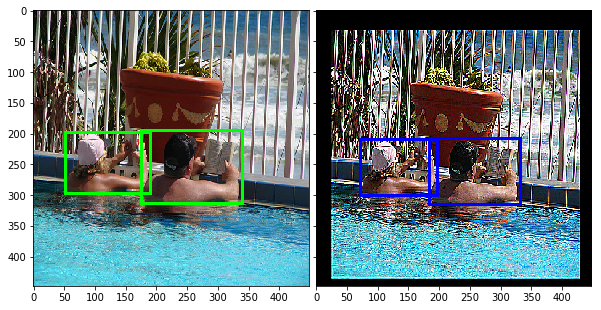

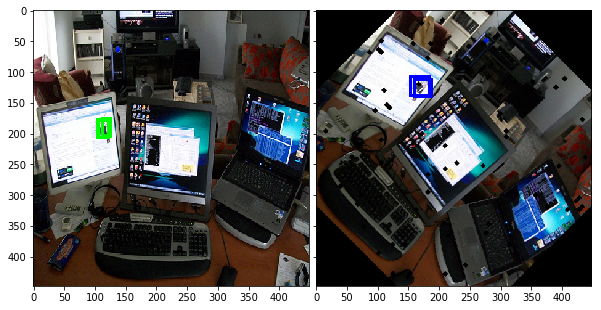

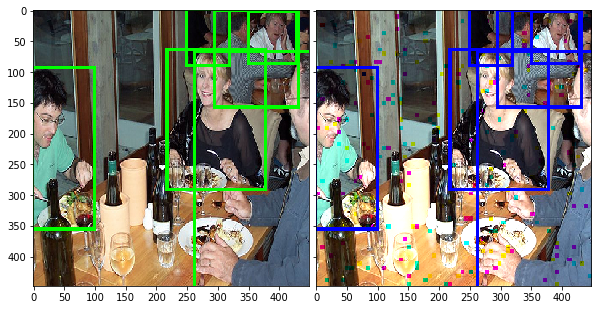

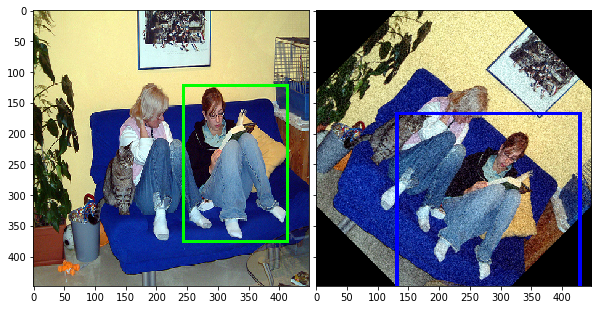

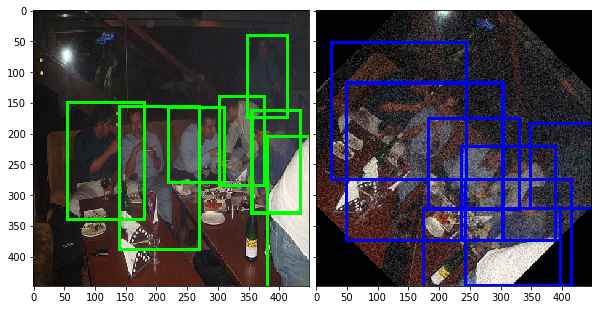

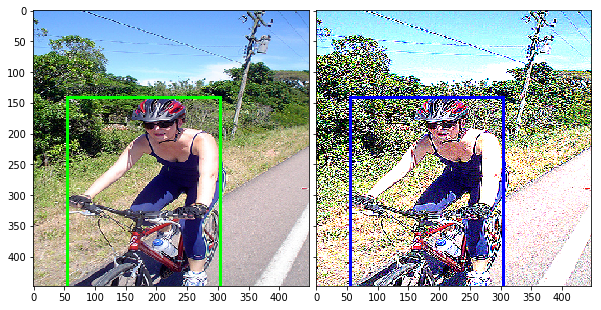

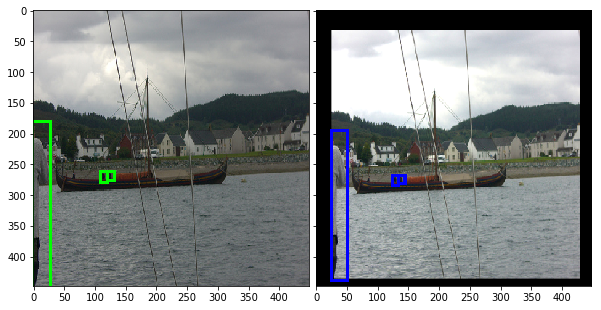

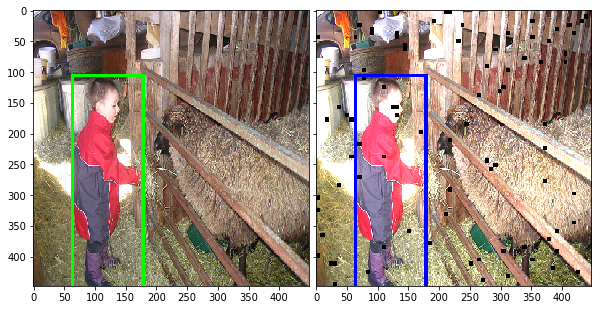

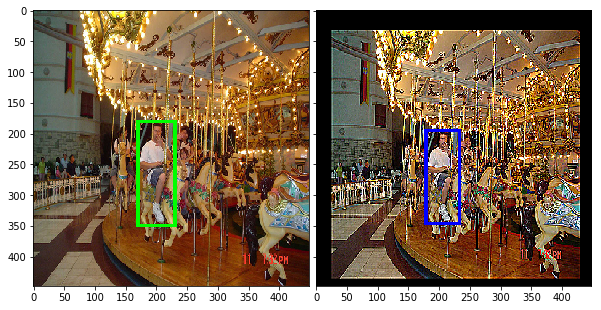

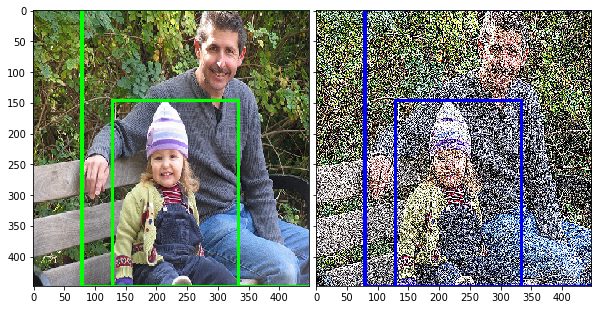

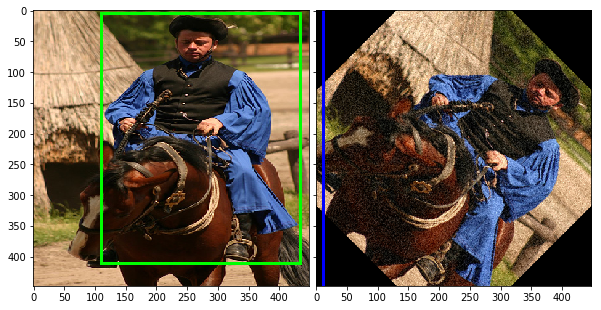

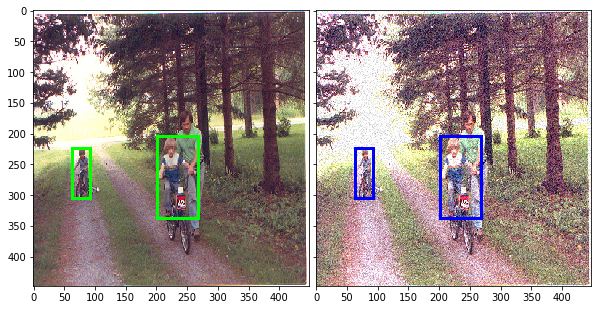

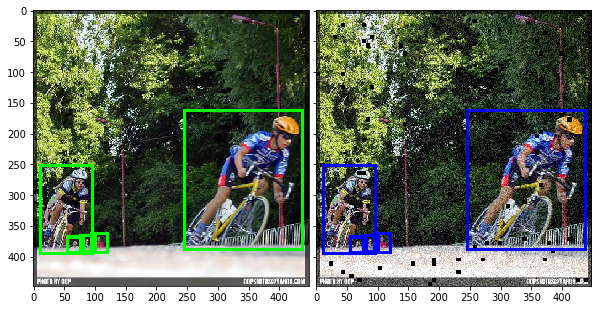

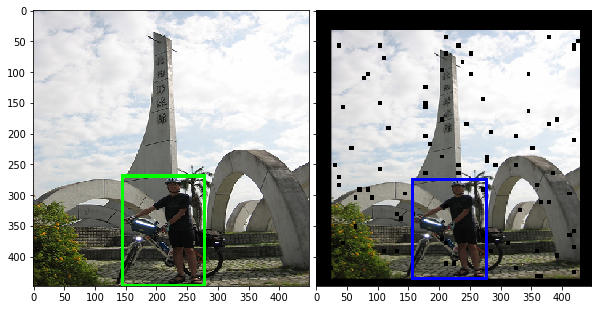

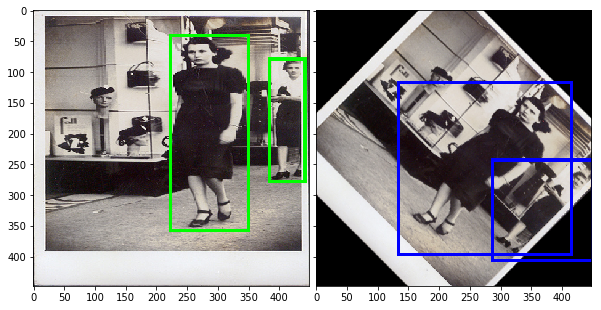

In [16]:
image, label = data_iterator.next()